In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM

In [38]:
df = pd.read_csv("crypto_price/data/BTC_15min_todate_indicators")
df.tail()

,date,high,low,open,close,volume,middle,cr,cr-ma1,cr-ma2,...,boll_lb,open_-2_r,close_-1_s,close_-1_d,rs_14,rsi_14,macd,macds,macdh,tema
26273,2021-03-03 12:30:00,52232.624343,51629.542023,51629.542023,52187.803629,1.533021e+06,52016.656665,274.357011,245.579371,284.604017,...,50048.344101,-0.063214,51610.887183,576.916445,2.530910,71.678690,570.786517,588.391735,-17.605218,51990.403501
26274,2021-03-03 12:45:00,52550.765704,52072.117284,52190.413452,52523.537866,1.012147e+06,52382.140285,305.071542,242.636573,280.747813,...,50264.419220,1.585497,52187.803629,335.734237,2.920717,74.494458,611.923888,593.098166,18.825723,52419.180802
26275,2021-03-03 13:00:00,52605.813647,51862.326539,52533.571395,52024.480000,1.012871e+06,52164.206729,251.179974,242.640364,271.986798,...,50512.904094,1.750992,52523.537866,-499.057866,1.798464,64.266110,597.369647,593.952462,3.417185,52231.471657
26276,2021-03-03 13:15:00,52034.805443,51625.100000,51998.181885,51763.025526,1.478014e+06,51807.643656,205.349266,244.320803,266.817928,...,50640.501729,-0.368327,52024.480000,-261.454474,1.478045,59.645602,558.302353,586.822440,-28.520087,51939.915853
26277,2021-03-03 13:30:00,51975.347829,51486.143048,51779.306800,51635.718529,8.334356e+05,51699.069802,190.601590,260.038041,263.753538,...,50783.636270,-1.435776,51763.025526,-127.306997,1.351758,57.478621,511.176111,571.693174,-60.517064,51713.243299


In [9]:
df_new = df[["date", "close"]].copy()
df_new.head()


,date,close
0,2020-06-02 20:18:30,9495.164556
1,2020-06-02 20:30:00,9497.135448
2,2020-06-02 20:45:00,9525.998354
3,2020-06-02 21:00:00,9518.000000
4,2020-06-02 21:15:00,9527.171968


In [11]:
df_new[["ds", "y"]] = df_new[["date", "close"]]
df_new.head()

,date,close,ds,y
0,2020-06-02 20:18:30,9495.164556,2020-06-02 20:18:30,9495.164556
1,2020-06-02 20:30:00,9497.135448,2020-06-02 20:30:00,9497.135448
2,2020-06-02 20:45:00,9525.998354,2020-06-02 20:45:00,9525.998354
3,2020-06-02 21:00:00,9518.000000,2020-06-02 21:00:00,9518.000000
4,2020-06-02 21:15:00,9527.171968,2020-06-02 21:15:00,9527.171968


In [18]:
df_new = df_new.drop(columns = ["date", "close"])

In [12]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

<AxesSubplot:>

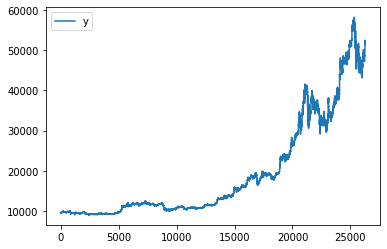

In [22]:
df_new.plot()

In [20]:

train_split = 0.8
num_train = int(train_split * df_new.shape[0])

train = df_new.iloc[:num_train]
test = df_new.iloc[num_train:]

In [21]:
train.shape, test.shape

((21022, 2), (5256, 2))

In [24]:
model = Prophet(seasonality_mode='multiplicative', interval_width=0.95,  yearly_seasonality=True,
        weekly_seasonality='auto',
        daily_seasonality=True,)
model.fit(train)

In [26]:
future = model.make_future_dataframe(periods=300, freq='H')
fct = model.predict(future)
fct

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-06-02 20:18:30,2615.536487,8518.300909,10251.098889,2615.536487,2615.536487,0.000383,0.000383,0.000383,2.581832,...,-0.006835,-0.006835,-0.006835,2.588284,2.588284,2.588284,0.0,0.0,0.0,9368.412633
1,2020-06-02 20:30:00,2615.582196,8543.961506,10288.062994,2615.582196,2615.582196,0.000344,0.000344,0.000344,2.582404,...,-0.006787,-0.006787,-0.006787,2.588847,2.588847,2.588847,0.0,0.0,0.0,9370.073035
2,2020-06-02 20:45:00,2615.641816,8501.865389,10243.898984,2615.641816,2615.641816,0.000289,0.000289,0.000289,2.583146,...,-0.006723,-0.006723,-0.006723,2.589580,2.589580,2.589580,0.0,0.0,0.0,9372.226217
3,2020-06-02 21:00:00,2615.701437,8477.545299,10288.984791,2615.701437,2615.701437,0.000236,0.000236,0.000236,2.583886,...,-0.006659,-0.006659,-0.006659,2.590310,2.590310,2.590310,0.0,0.0,0.0,9374.376696
4,2020-06-02 21:15:00,2615.761057,8501.021545,10246.621337,2615.761057,2615.761057,0.000189,0.000189,0.000189,2.584631,...,-0.006595,-0.006595,-0.006595,2.591038,2.591038,2.591038,0.0,0.0,0.0,9376.537711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21317,2021-01-20 03:30:00,106308.290688,38161.267054,40478.085288,103904.659826,109006.522735,0.000514,0.000514,0.000514,-0.630023,...,-0.004953,-0.004953,-0.004953,-0.625584,-0.625584,-0.625584,0.0,0.0,0.0,39331.668330
21318,2021-01-20 04:30:00,106368.759724,37898.902789,40326.951271,103945.021169,109078.635282,0.000192,0.000192,0.000192,-0.632090,...,-0.004684,-0.004684,-0.004684,-0.627598,-0.627598,-0.627598,0.0,0.0,0.0,39134.102485
21319,2021-01-20 05:30:00,106429.228759,37874.652148,40184.696771,103985.382511,109150.747829,0.000244,0.000244,0.000244,-0.633804,...,-0.004414,-0.004414,-0.004414,-0.629634,-0.629634,-0.629634,0.0,0.0,0.0,38973.925688
21320,2021-01-20 06:30:00,106489.697795,37637.977537,40106.314945,104025.743854,109222.860376,0.000422,0.000422,0.000422,-0.635411,...,-0.004142,-0.004142,-0.004142,-0.631692,-0.631692,-0.631692,0.0,0.0,0.0,38824.922558


In [32]:
fct["yhat"].describe

<bound method NDFrame.describe of 0         9368.412633
1         9370.073035
2         9372.226217
3         9374.376696
4         9376.537711
             ...     
21317    39331.668330
21318    39134.102485
21319    38973.925688
21320    38824.922558
21321    38637.031746
Name: yhat, Length: 21322, dtype: float64>

In [34]:
df_new["y"][:21322].describe

<bound method NDFrame.describe of 0         9495.164556
1         9497.135448
2         9525.998354
3         9518.000000
4         9527.171968
             ...     
21317    37849.704897
21318    38077.565265
21319    38735.122012
21320    38846.980022
21321    38802.945961
Name: y, Length: 21322, dtype: float64>

In [29]:
horizon = 36
futures = model.make_future_dataframe(periods=horizon, freq='MS')
forecast = model.predict(futures)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
21053,2023-09-01 19:30:00,3.790785e+06,-100714.197262,8.073406e+06
21054,2023-10-01 19:30:00,7.026273e+06,-226579.395085,1.513572e+07
21055,2023-11-01 19:30:00,4.026330e+06,-189255.352011,8.703283e+06
21056,2023-12-01 19:30:00,8.928219e+05,-58237.188203,1.946000e+06
21057,2024-01-01 19:30:00,6.056077e+05,-56772.981586,1.314022e+06


In [37]:
from sklearn.metrics import mean_absolute_error
res = mean_absolute_error(df_new["y"][:21322], fct["yhat"])
res

340.0769860382414

In [39]:
from sklearn.metrics import mean_squared_error
result = mean_squared_error(df_new["y"][:21322], fct["yhat"])
result

609771.9708340649